### Run basic `scanpy` QC and doublet detection with `scrublet` for merged PBMC dataset

- **Developed by**: Carlos Talavera-López PhD
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v230810

### Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.2
-----
PIL                 9.4.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
cffi                1.15.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
executing           1.2.0
h5py                3.8.0
igraph              0.10.4
importlib_resources NA
ipykernel           6.21.2
ipywidgets          8.0.7
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.7.0
mpl_toolkits        NA
natsort             8.2.0
numba               0.56.4
numexpr             2.8.4
numpy               1.23.5
packaging           23.0
pandas              1.5.3
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        3.0.

In [3]:
save_path = '../data/'

### Read individual `anndata` objects and predict doublets per sample

In [4]:
adata = sc.read_h5ad('../data/merged_pbmc_yoshida-imyoo_ctl230808_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 250219 × 31908
    obs: 'sample', 'seed_labels', 'donor', 'cell_states', 'generator'
    var: 'name-ImYoo_2023', 'id-ImYoo_2023', 'name-YoshidaM_2022'

In [5]:
sc.pp.filter_cells(adata, min_genes = 200)
print(adata.n_obs, adata.n_vars)

filtered out 61 cells that have less than 200 genes expressed
250158 31908


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 51.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.0%
Elapsed time: 1219.2 seconds


1351

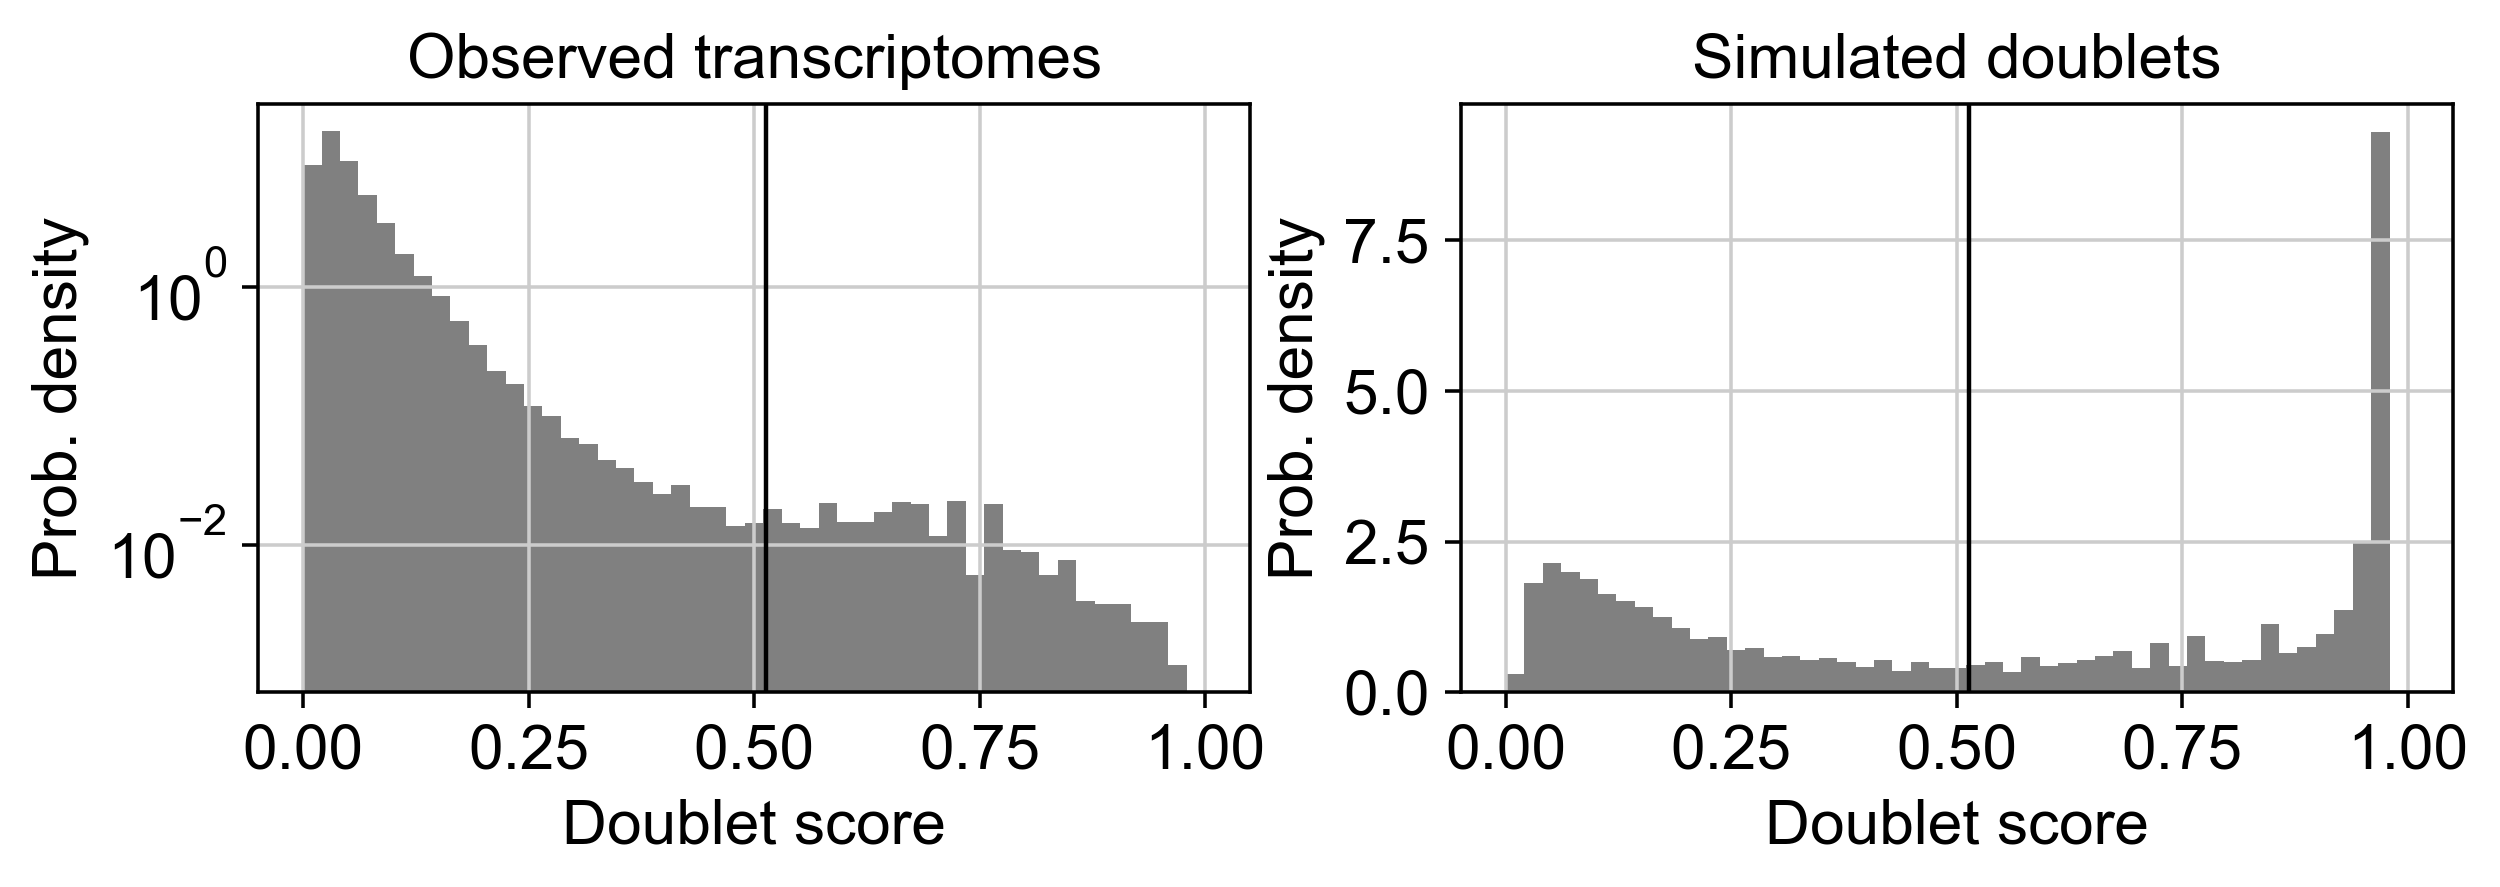

In [6]:
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [7]:
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 250158 × 31908
    obs: 'sample', 'seed_labels', 'donor', 'cell_states', 'generator', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'name-ImYoo_2023', 'id-ImYoo_2023', 'name-YoshidaM_2022'

In [8]:
sample_object.shape

(250158, 31908)

### Compute QC stats

In [9]:
sample_object.shape

(250158, 31908)

In [10]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('MT-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("RPS","RPL"))
sample_object.var

,name-ImYoo_2023,id-ImYoo_2023,name-YoshidaM_2022,mt,ribo
MIR1302-2HG,MIR1302-2HG,ENSG00000243485,MIR1302-2HG,False,False
FAM138A,FAM138A,ENSG00000237613,FAM138A,False,False
OR4F5,OR4F5,ENSG00000186092,OR4F5,False,False
AL627309.1,AL627309.1,ENSG00000238009,AL627309.1,False,False
AL627309.3,AL627309.3,ENSG00000239945,AL627309.3,False,False
...,...,...,...,...,...
AC023491.2,AC023491.2,ENSG00000278633,AC023491.2,False,False
AC233755.2,AC233755.2,ENSG00000277856,AC233755.2,False,False
AC233755.1,AC233755.1,ENSG00000275063,AC233755.1,False,False
AC240274.1,AC240274.1,ENSG00000271254,AC240274.1,False,False


In [11]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [12]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.var_names.str.startswith('MT-')
sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1)
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1)

In [13]:
sample_object

AnnData object with n_obs × n_vars = 250158 × 31908
    obs: 'sample', 'seed_labels', 'donor', 'cell_states', 'generator', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'name-ImYoo_2023', 'id-ImYoo_2023', 'name-YoshidaM_2022', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise QC covariates

In [14]:
sample_object.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.1', 'AC007325.4', 'AC007325.2', 'BX072566.1', 'AL354822.1',
       'AC023491.2', 'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1'],
      dtype='object', length=31908)

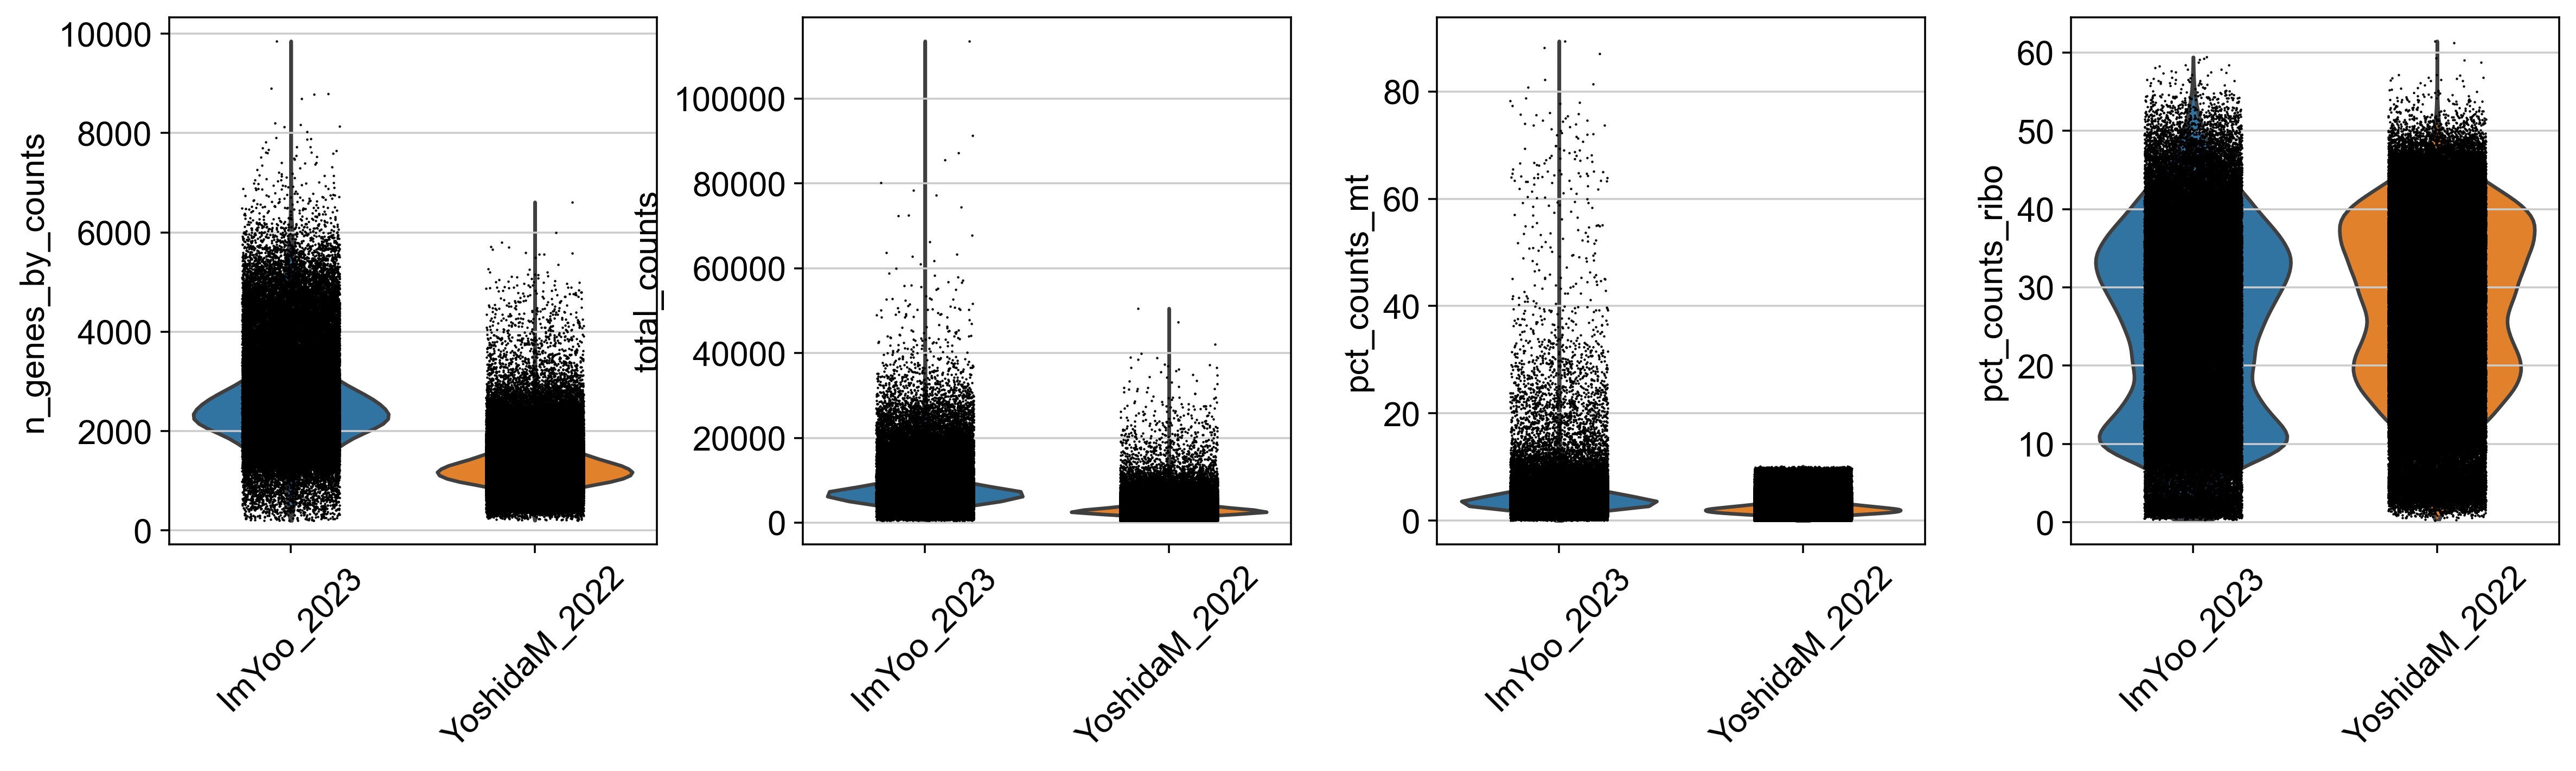

In [17]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'generator', rotation = 45)

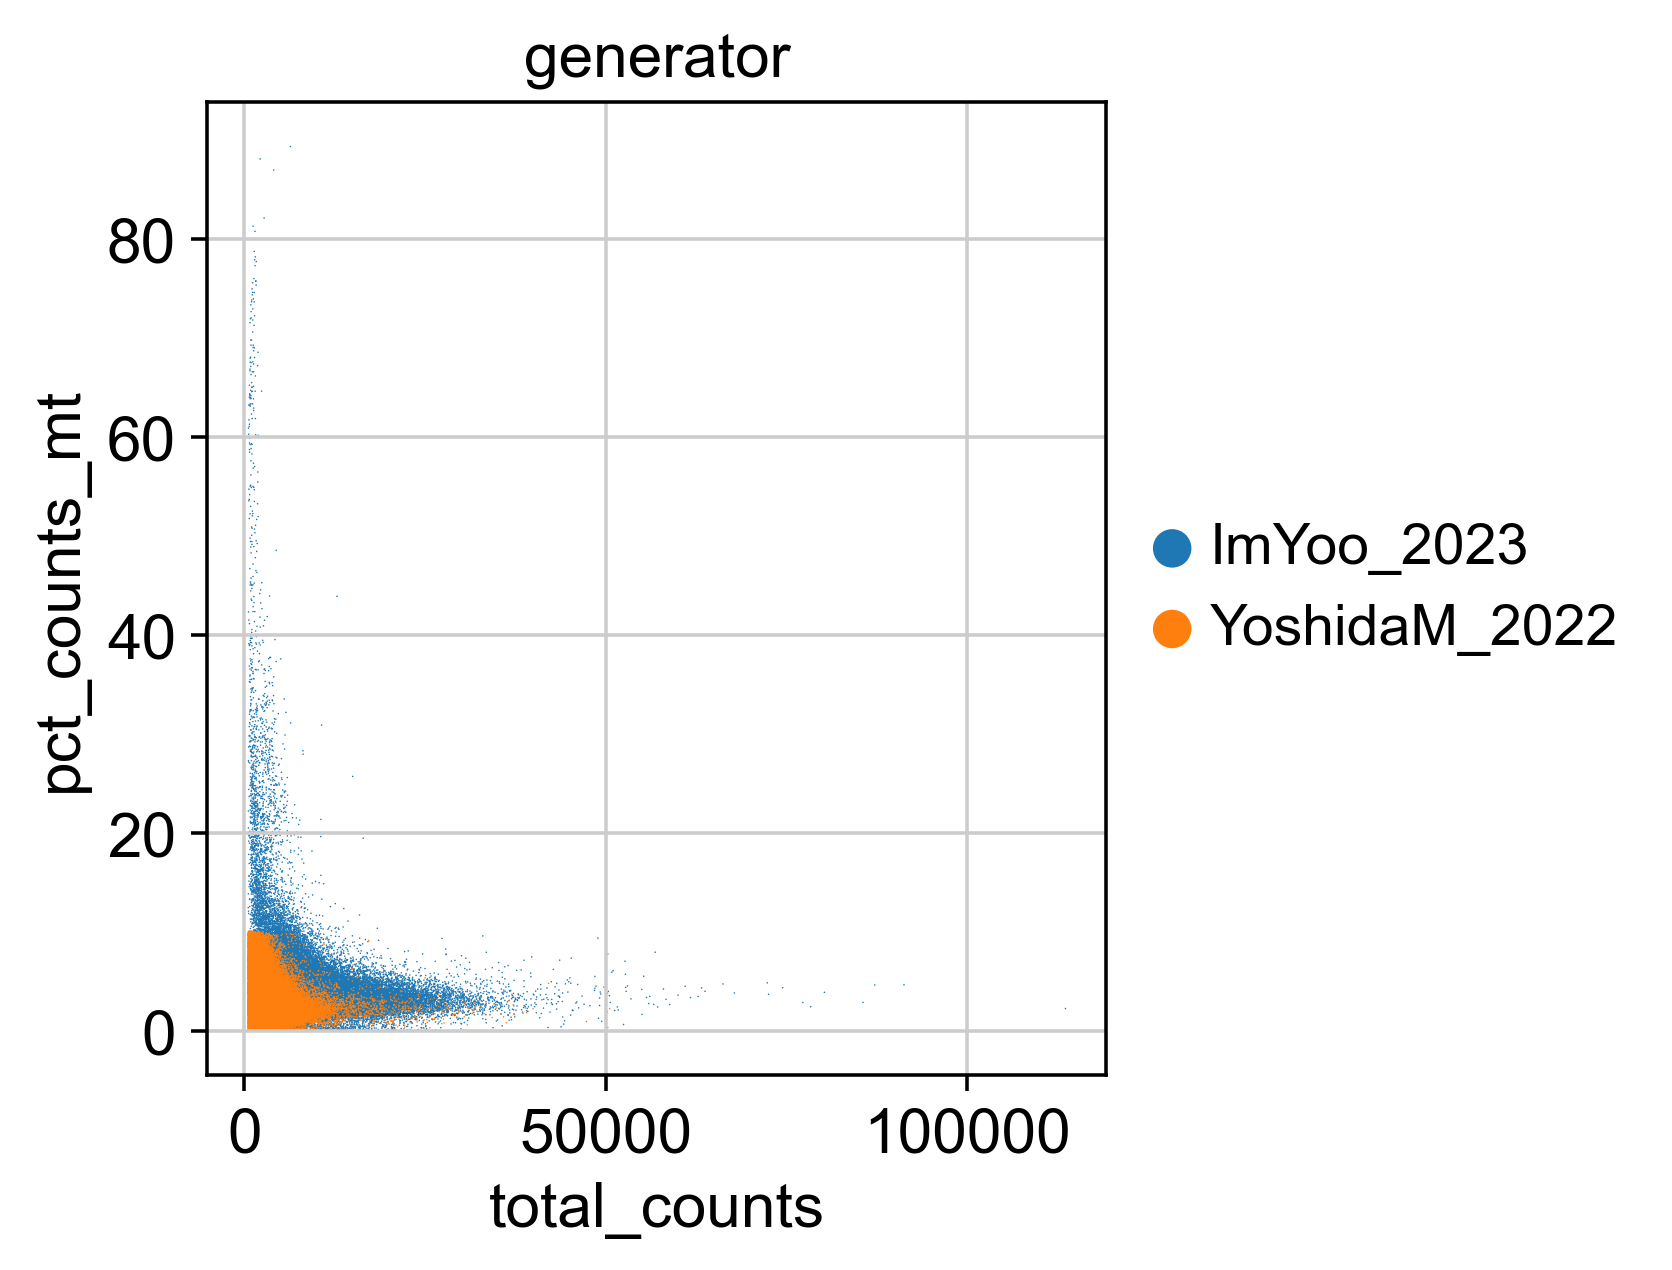

In [18]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "generator")

### Add sample sex covariate

In [19]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [20]:
annot.head()

,ensembl_gene_id,start_position,end_position,chromosome_name
external_gene_name,,,,
MT-TF,ENSG00000210049,577,647,MT
MT-RNR1,ENSG00000211459,648,1601,MT
MT-TV,ENSG00000210077,1602,1670,MT
MT-RNR2,ENSG00000210082,1671,3229,MT
MT-TL1,ENSG00000209082,3230,3304,MT


In [21]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['PLCXD1', 'GTPBP6', 'LINC00685', 'PPP2R3B', 'SHOX', 'CRLF2', 'CSF2RA',
       'IL3RA', 'SLC25A6', 'LINC00106',
       ...
       'TTTY17B', 'TTTY4B', 'BPY2B', 'DAZ3', 'DAZ4', 'BPY2C', 'TTTY4C',
       'TTTY17C', 'CDY1', 'TTTY3'],
      dtype='object', length=106)

In [22]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1) * 100

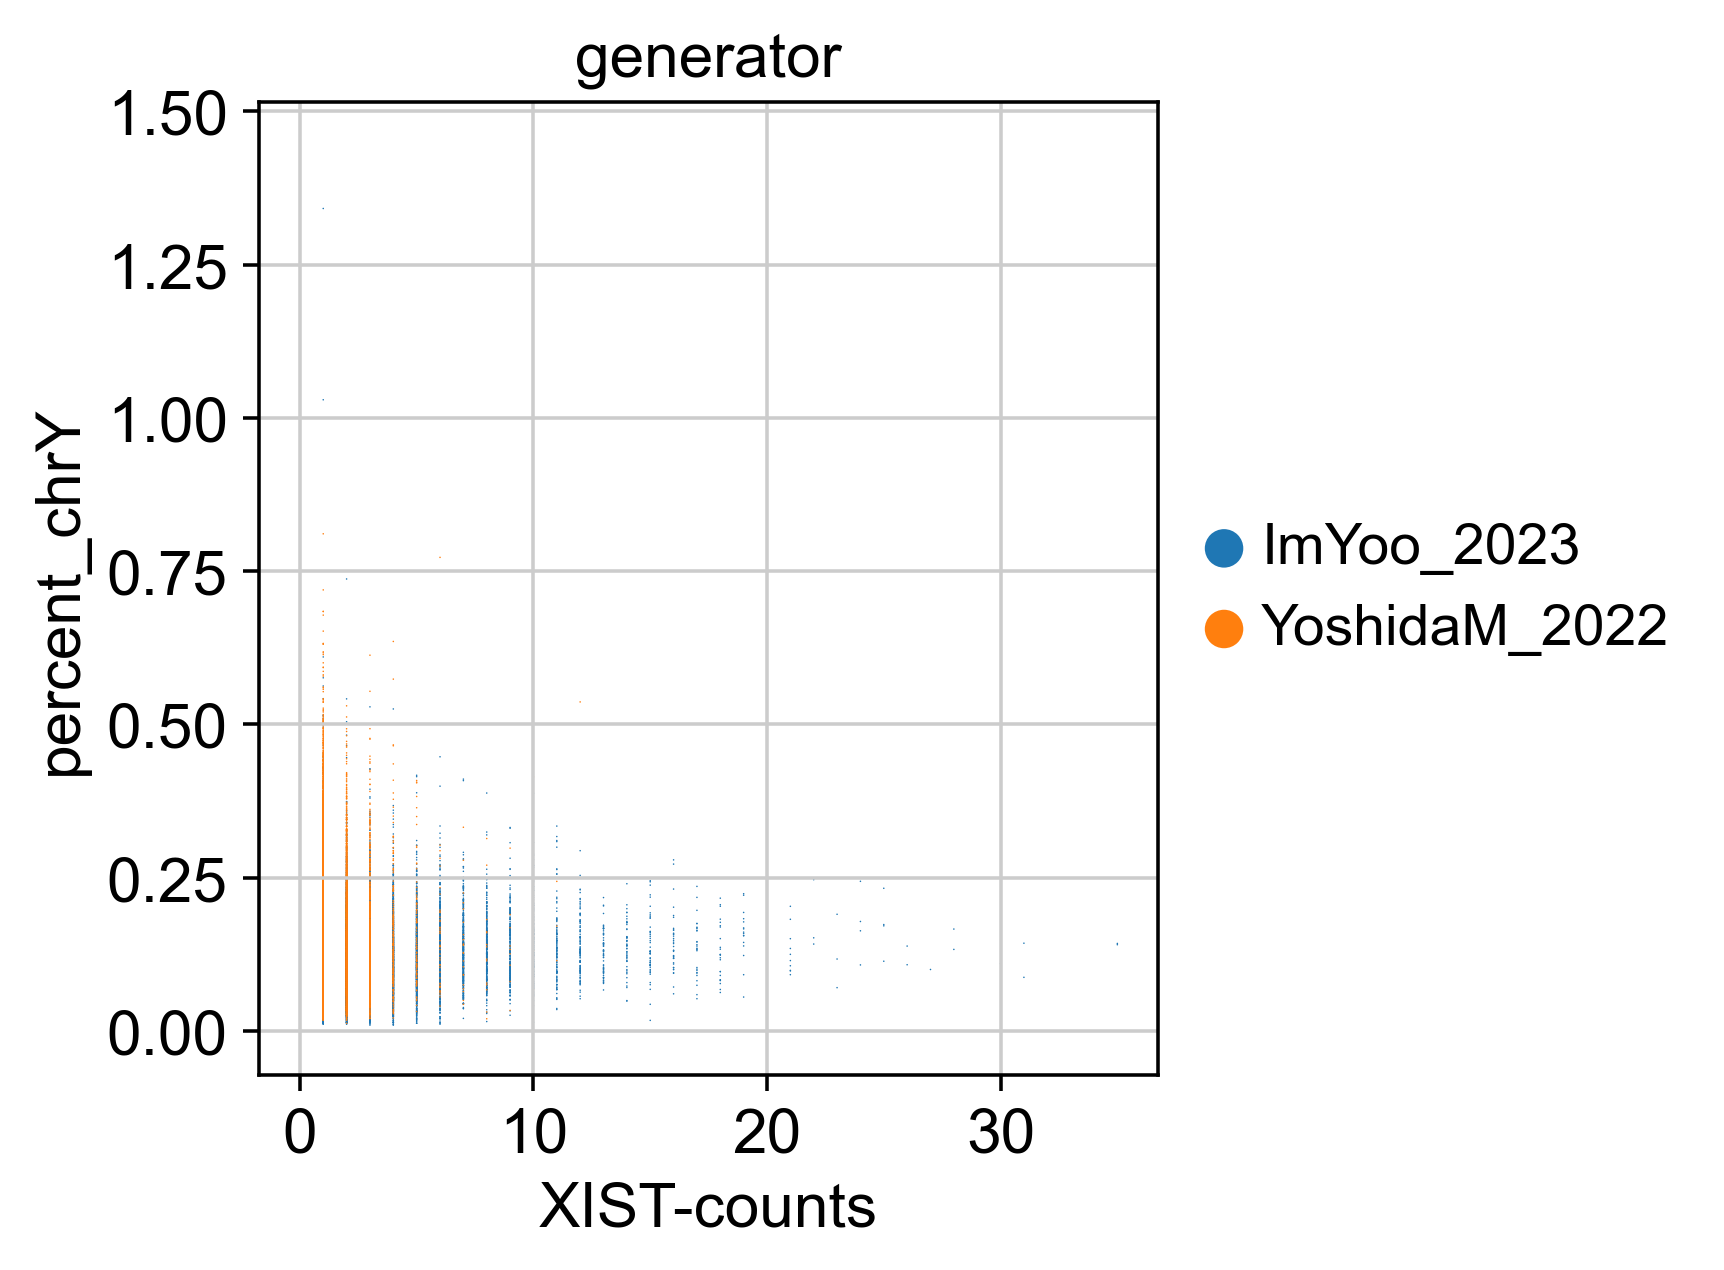

In [24]:
xist_counts = sample_object.X[:, sample_object.var_names.str.match('XIST')].toarray()
xist_counts_series = pd.Series(xist_counts.squeeze(), index = sample_object.obs_names, name = "XIST-counts")
sample_object.obs["XIST-counts"] = xist_counts_series

sc.pl.scatter(sample_object, x = 'XIST-counts', y = 'percent_chrY', color = "generator")

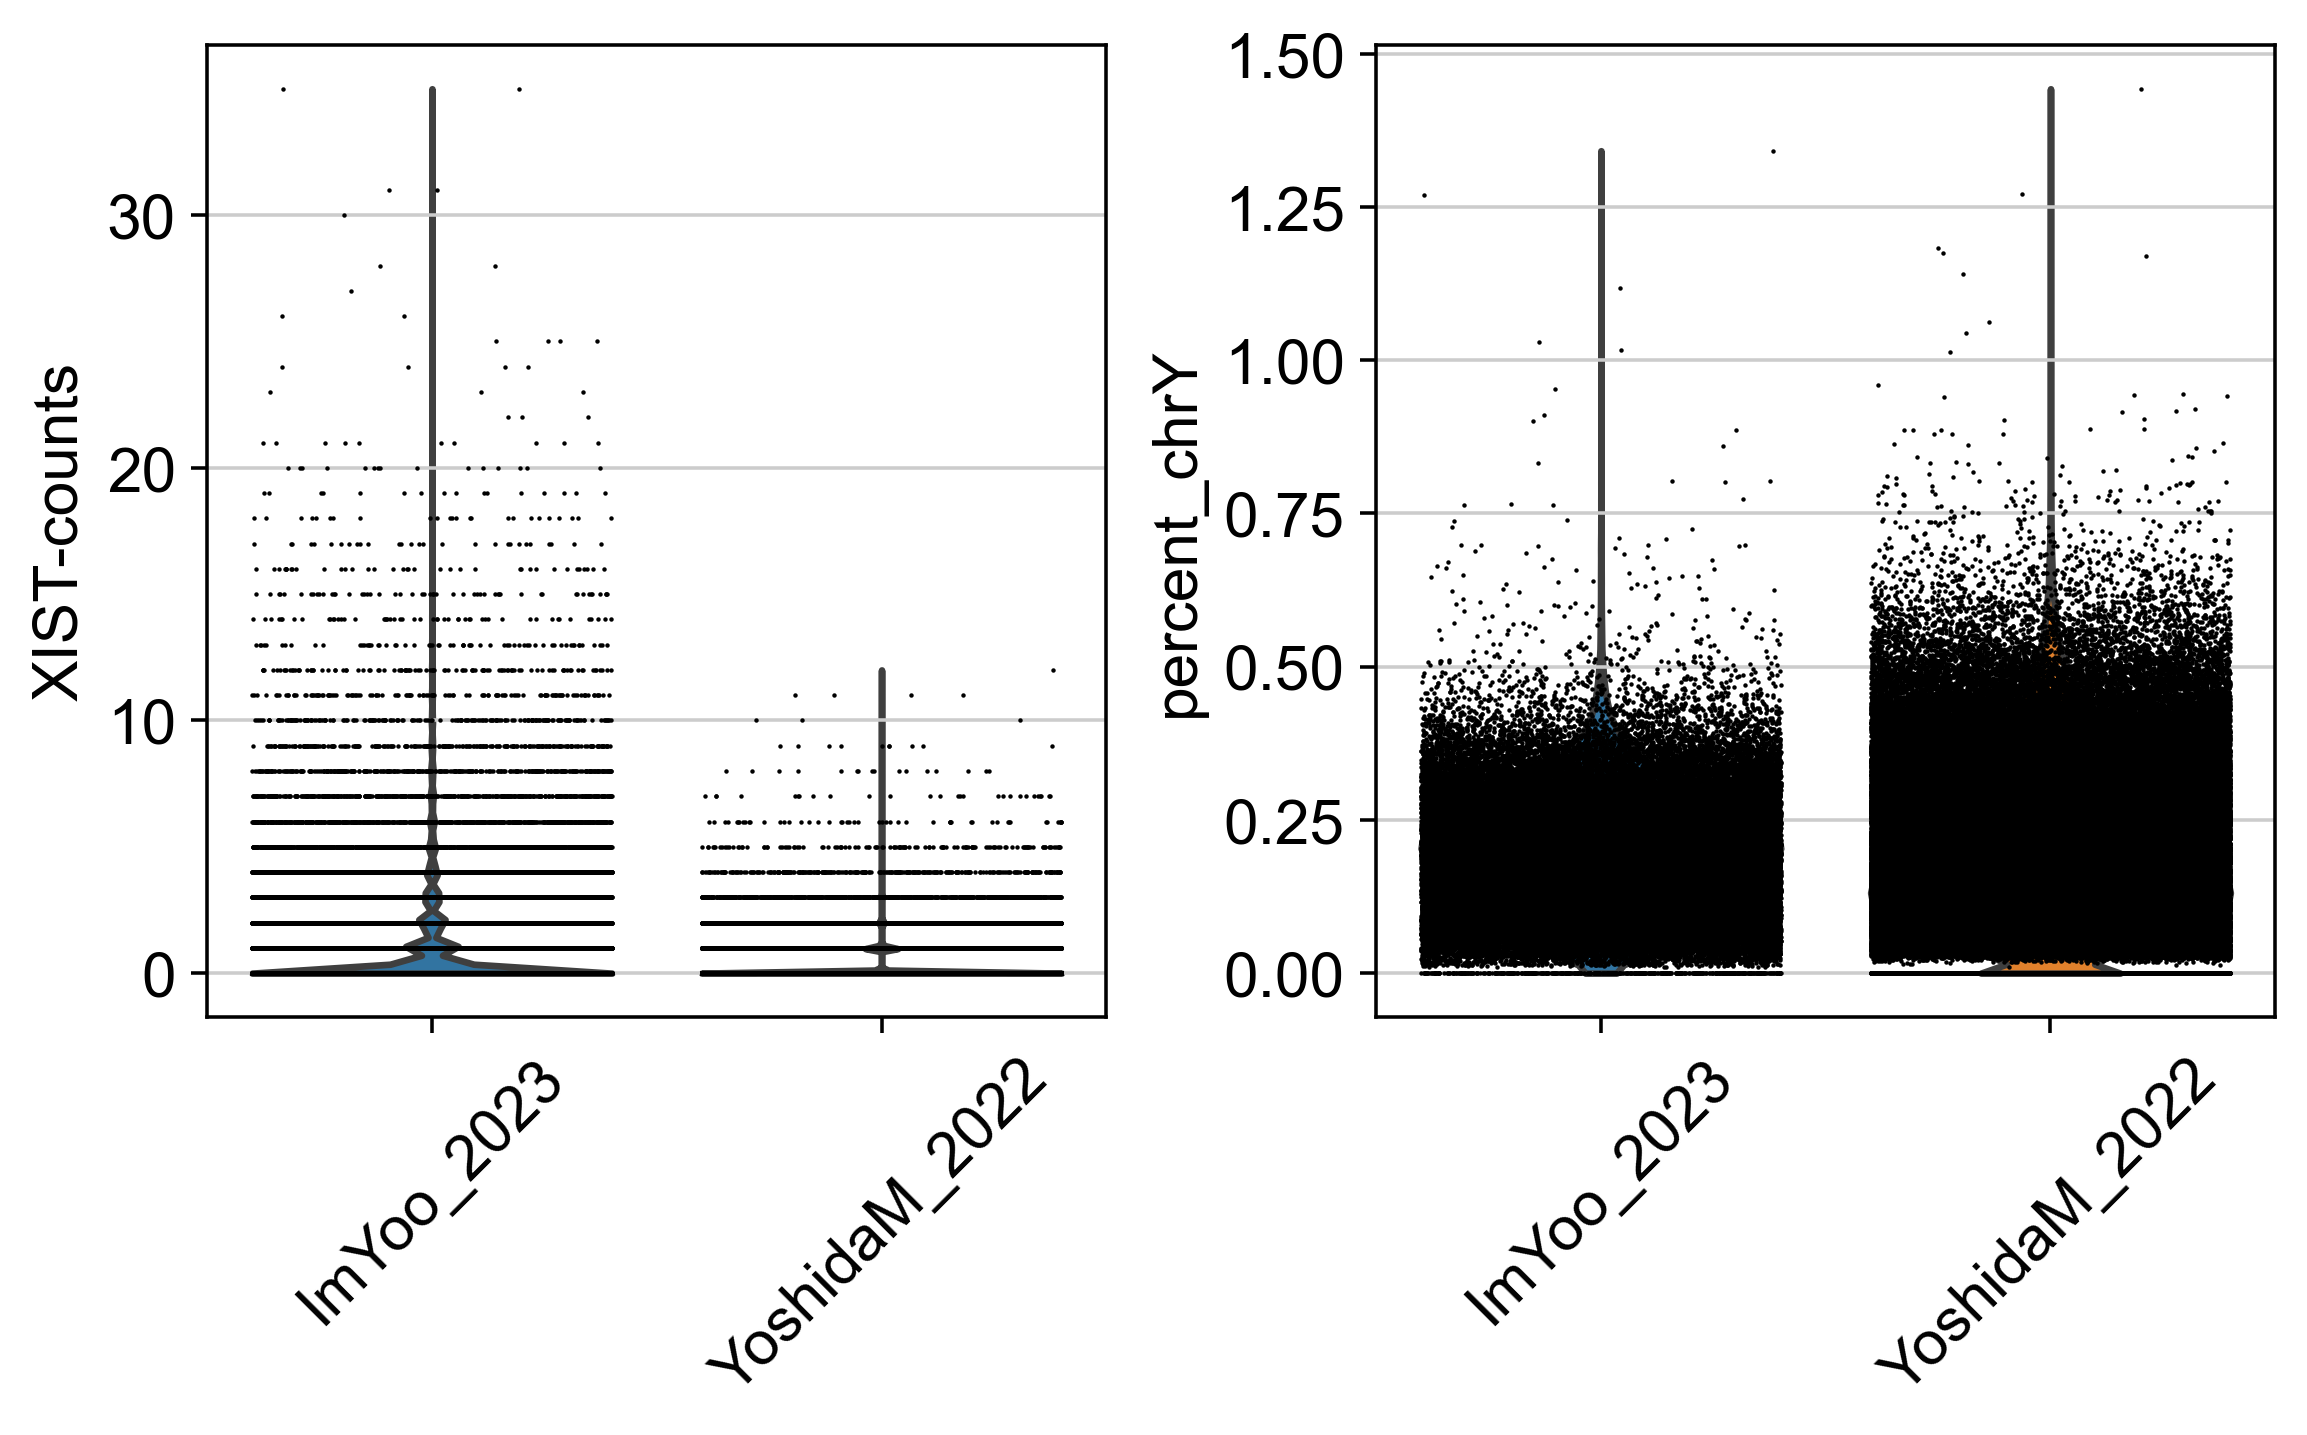

In [25]:
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'generator', rotation = 45)

### Calculate cell cycle scores

In [26]:
!if [ ! -f ../data/regev_lab_cell_cycle_genes.txt ]; then curl -o ../data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   556  100   556    0     0   2286      0 --:--:-- --:--:-- --:--:--     0-:--:-- --:--:-- --:--:--  2336


In [27]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [28]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['S100A9', 'S100A12', 'S100A8', 'GNLY', 'IGKC', 'IGKV4-1', 'IGKV5-2', 'IGKV1-5', 'IGKV1-6', 'IGKV1-8', 'IGKV1-9', 'IGKV3-11', 'IGKV1-12', 'IGKV3-15', 'IGKV1-16', 'IGKV1-17', 'IGKV3-20', 'IGKV2-24', 'IGKV1-27', 'IGKV2-29', 'IGKV2-30', 'IGKV1-33', 'IGKV1-39', 'IGKV2D-40', 'IGKV1D-39', 'IGKV1D-33', 'IGKV2D-30', 'IGKV2D-29', 'IGKV3D-20', 'IGKV1D-16', 'IGKV1D-13', 'JCHAIN', 'PPBP', 'CD74', 'HSPA1A', 'ACTB', 'TMSB4X', 'SLC25A37', 'PTGDS', 'HBB', 'HBG2', 'FTH1', 'NEAT1', 'MALAT1', 'LYZ', 'FOS', 'IGHA2', 'IGHG4', 'IGHG2', 'IGHGP', 'IGHA1', 'IGHG1', 'IGHG3', 'IGHM', 'IGHV6-1', 'IGHV1-2', 'IGHV4-4', 'IGHV2-5', 'IGHV3-7', 'IGHV5-10-1', 'IGHV3-11', 'IGHV3-13', 'IGHV3-15', 'IGHV1-18', 'IGHV3-20', 'IGHV3-21', 'IGHV3-23', 'IGHV2-26', 'IGHV3-30', 'IGHV3-33', 'IGHV4-34', 'IGHV4-39', 'IGHV3-43', 'IGHV1-46', 'IGHV3-48', 'IGHV3-49', 'IGHV5-51', 'IGHV3-53', 'IGHV1-58', 'IGHV4-59', 'I

calculating cell cycle phase
computing score 'S_score'


/Users/cartalop/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'S_score', score of gene set (adata.obs).
    471 total control genes are used. (0:00:07)
computing score 'G2M_score'


/Users/cartalop/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'G2M_score', score of gene set (adata.obs).
    516 total control genes are used. (0:00:07)
-->     'phase', cell cycle phase (adata.obs)


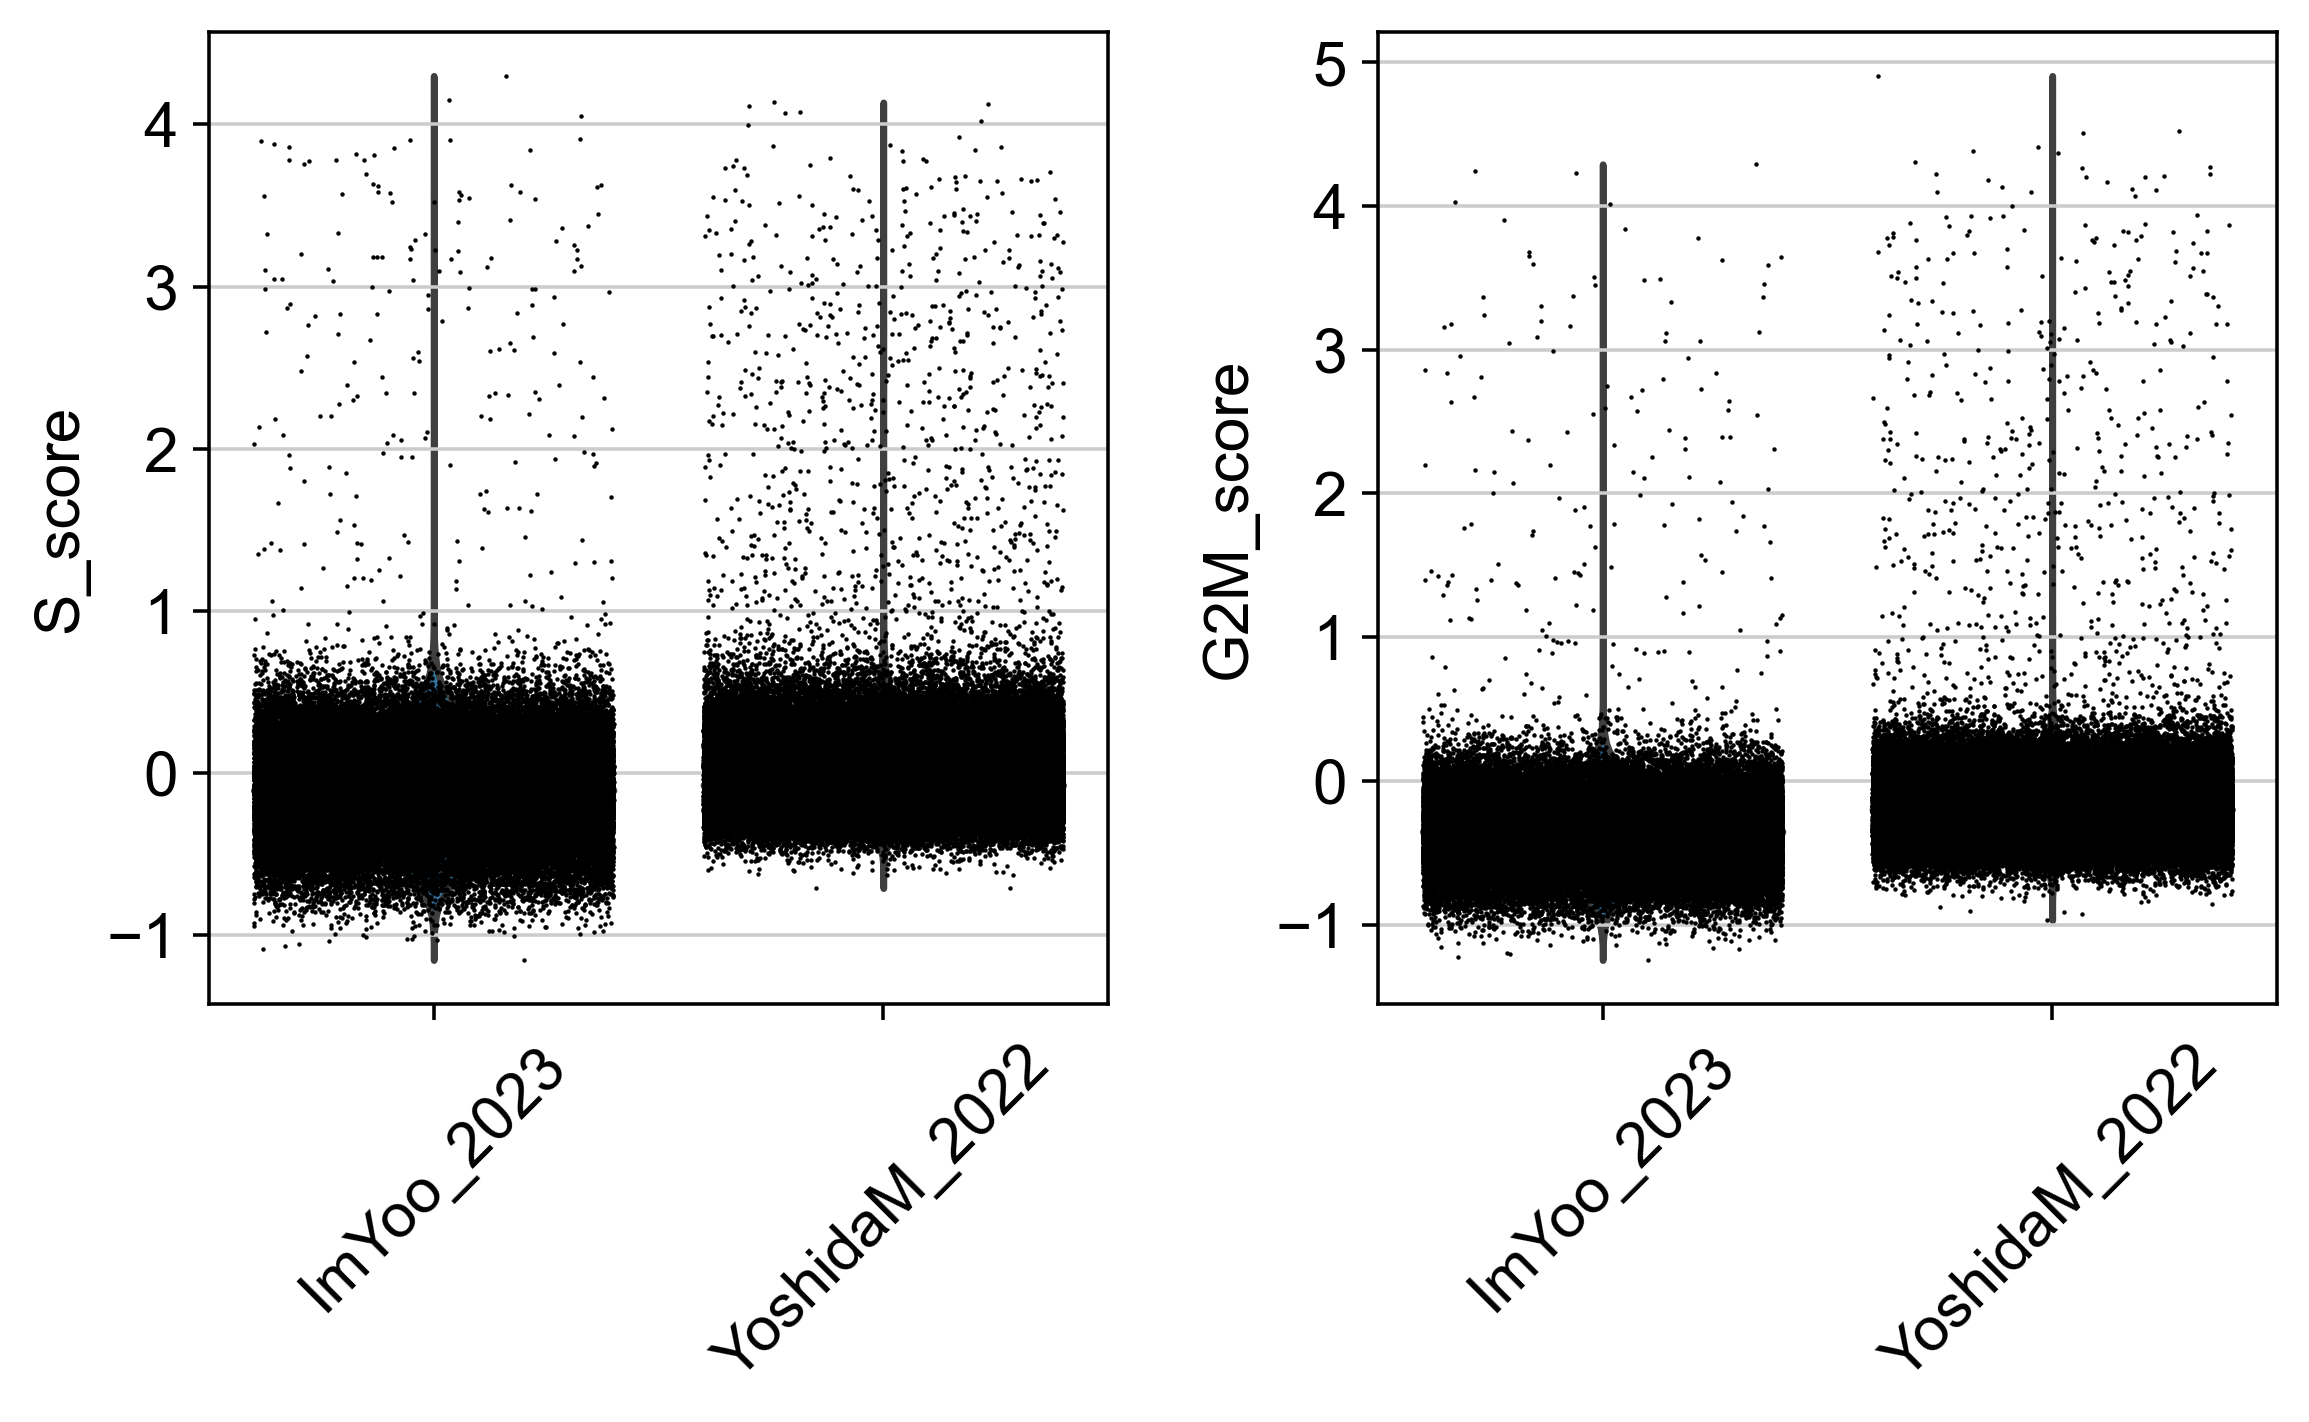

In [29]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'generator', rotation = 45)

In [30]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

AnnData object with n_obs × n_vars = 250158 × 31908
    obs: 'sample', 'seed_labels', 'donor', 'cell_states', 'generator', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'name-ImYoo_2023', 'id-ImYoo_2023', 'name-YoshidaM_2022', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors', 'generator_colors'

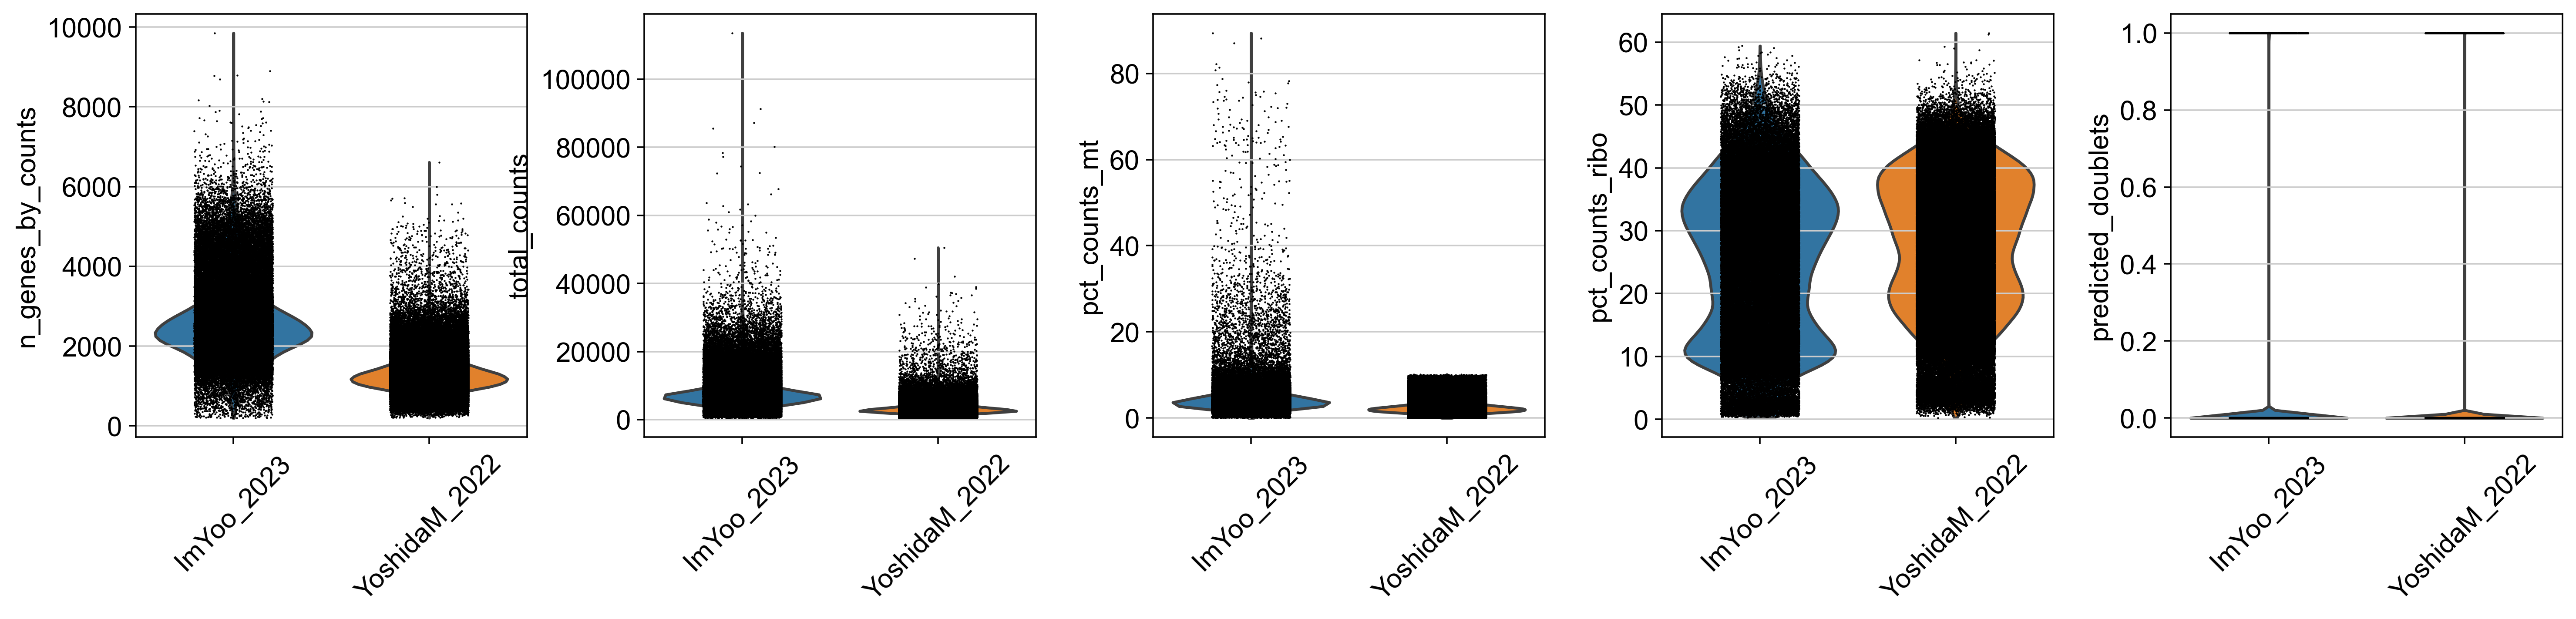

In [31]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'generator', rotation = 45)

### Prepare counts for individual slots

In [32]:
sample_object.raw = sample_object.copy()
#sample_object.layers['counts'] = sample_object.X.copy()
#sample_object.layers["sqrt_norm"] = np.sqrt(
#    sc.pp.normalize_total(sample_object, inplace = False)["X"]
#)
sample_object

AnnData object with n_obs × n_vars = 250158 × 31908
    obs: 'sample', 'seed_labels', 'donor', 'cell_states', 'generator', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'name-ImYoo_2023', 'id-ImYoo_2023', 'name-YoshidaM_2022', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors', 'generator_colors'

### Export object

In [33]:
sample_object.write(save_path + 'merged_pbmc_yoshida-imyoo_QCed_pre-processed_ctl230810.h5ad')